# Detect Phishing URLs
### Capstone 3 - Preprocessing and Modeling
Michael Garber

#### High-Level Steps
1. Preprocessing
    1. Create dummy/indicator features for categorical variables
    2. Standardize/scale numeric features
    3. Train/Test Split 
2. Modeling
    1. Fit your models with a training dataset
    2. Review model outcomes — Iterate over additional models as needed.
    3. Identify the final model that you think is the best model for this project

In [3]:
# Import Libraries
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import TargetEncoder     # requires scikit-learn 1.3 or greater
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve, auc
import keras
from keras import layers
import seaborn as sns
import matplotlib.pyplot as plt

#### Preprocessing

In [5]:
# Import Data set
dataDir = os.path.join('../data/interim/urlData_raw.csv')
urlData = pd.read_csv(dataDir)

C:\Users\MG-Laptop\AppData\Local\Temp\ipykernel_5080\2659773463.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  urlData = pd.read_csv(dataDir)


In [6]:
# add new useful feature: URL length
urlData['url_Length'] = urlData['url'].apply(len)

In [7]:
# Data Info
urlData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450175 entries, 0 to 450174
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Unnamed: 0        450175 non-null  int64 
 1   key_0             445854 non-null  object
 2   url               450175 non-null  object
 3   type              450175 non-null  object
 4   parsedUrl         450175 non-null  object
 5   urlPart_scheme    450175 non-null  object
 6   subDomain         379885 non-null  object
 7   domain            450167 non-null  object
 8   tld               445854 non-null  object
 9   urlPart_path      444917 non-null  object
 10  urlPart_query     65541 non-null   object
 11  urlPart_fragment  359 non-null     object
 12  tld_join          445854 non-null  object
 13  Domain            445451 non-null  object
 14  Type              445451 non-null  object
 15  TLD Manager       445451 non-null  object
 16  isIPaddress       450175 non-null  boo

**Additional data cleaning** - identify features that have **missing values** (that we ares till planning on keeping)
- subDomain
- domain
- tld
- urlPart_path
- urlPart_query
- urlPart_fragment
- Type
- TLD Manager    

In [9]:
# Additional data cleaning - set missing values to zero
values = {
    'subDomain': '0',
    'domain': '0',
    'tld': '0',
    'urlPart_path': '0',
    'urlPart_query': '0',
    'urlPart_fragment': '0',
    'Type': '0',
    'TLD Manager': '0'}

urlData = urlData.fillna(value=values)

In [10]:
# Data Info - checking NULLs again (key and tld will be dropped)
urlData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450175 entries, 0 to 450174
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Unnamed: 0        450175 non-null  int64 
 1   key_0             445854 non-null  object
 2   url               450175 non-null  object
 3   type              450175 non-null  object
 4   parsedUrl         450175 non-null  object
 5   urlPart_scheme    450175 non-null  object
 6   subDomain         450175 non-null  object
 7   domain            450175 non-null  object
 8   tld               450175 non-null  object
 9   urlPart_path      450175 non-null  object
 10  urlPart_query     450175 non-null  object
 11  urlPart_fragment  450175 non-null  object
 12  tld_join          445854 non-null  object
 13  Domain            445451 non-null  object
 14  Type              450175 non-null  object
 15  TLD Manager       450175 non-null  object
 16  isIPaddress       450175 non-null  boo

In [11]:
urlData.head()

,Unnamed: 0,key_0,url,type,parsedUrl,urlPart_scheme,subDomain,domain,tld,urlPart_path,urlPart_query,urlPart_fragment,tld_join,Domain,Type,TLD Manager,isIPaddress,isPhish_bool,url_Length
0,0,com,https://www.google.com,legitimate,"ParseResult(scheme='https', netloc='www.google...",https,www,google,com,0,0,0,com,.com,generic,VeriSign Global Registry Services,False,False,22
1,1,com,https://www.youtube.com,legitimate,"ParseResult(scheme='https', netloc='www.youtub...",https,www,youtube,com,0,0,0,com,.com,generic,VeriSign Global Registry Services,False,False,23
2,2,com,https://www.facebook.com,legitimate,"ParseResult(scheme='https', netloc='www.facebo...",https,www,facebook,com,0,0,0,com,.com,generic,VeriSign Global Registry Services,False,False,24
3,3,com,https://www.baidu.com,legitimate,"ParseResult(scheme='https', netloc='www.baidu....",https,www,baidu,com,0,0,0,com,.com,generic,VeriSign Global Registry Services,False,False,21
4,4,org,https://www.wikipedia.org,legitimate,"ParseResult(scheme='https', netloc='www.wikipe...",https,www,wikipedia,org,0,0,0,org,.org,generic,Public Interest Registry (PIR),False,False,25


In [12]:
urlData.columns[:]

Index(['Unnamed: 0', 'key_0', 'url', 'type', 'parsedUrl', 'urlPart_scheme',
       'subDomain', 'domain', 'tld', 'urlPart_path', 'urlPart_query',
       'urlPart_fragment', 'tld_join', 'Domain', 'Type', 'TLD Manager',
       'isIPaddress', 'isPhish_bool', 'url_Length'],
      dtype='object')

**Value Counts - urlPart_scheme**

In [14]:
#urlData[['url', 'urlPart_scheme', 'subDomain', 'tld', 'domain', 'type', 'TLD Manager', 'isIPaddress', 'isPhish_bool']]
pd.DataFrame(urlData['urlPart_scheme'].value_counts())

,count
urlPart_scheme,
https,352185
http,97947
httpss,35
ftp,8


**Value Counts - subDomain**

In [16]:
pd.DataFrame(urlData['subDomain'].value_counts())

,count
subDomain,
www,276100
0,70290
www.en,13626
www.music,1289
www.people,1228
...,...
www.ohv.parks,1
www.ohtheplaceswewillgo-books,1
www.ohr,1


**Value Counts - TLD Manager**

In [18]:
urlData['TLD Manager'].value_counts()

TLD Manager
VeriSign Global Registry Services                                                                               333004
Public Interest Registry (PIR)                                                                                   38393
Canadian Internet Registration Authority (CIRA) Autorité Canadienne pour les enregistrements Internet (ACEI)     10086
EDUCAUSE                                                                                                          6976
Nominet UK                                                                                                        5997
                                                                                                                 ...  
AS Domain Registry                                                                                                   1
University of Swaziland Department of Computer Science                                                               1
Dot London Domains Limited          

**Determine how to handle categorical features**

In [20]:
# Let's see cardinality / # of uniques for each feature - use to determine categorical fields to dummy and how to encode - one-hot vs label
urlData[['key_0', 'url', 'type', 'parsedUrl', 'urlPart_scheme',
       'subDomain', 'domain', 'tld', 'urlPart_path', 'urlPart_query',
       'urlPart_fragment', 'tld_join', 'Domain', 'Type', 'TLD Manager',
       'isIPaddress', 'isPhish_bool']].describe()

,key_0,url,type,parsedUrl,urlPart_scheme,subDomain,domain,tld,urlPart_path,urlPart_query,urlPart_fragment,tld_join,Domain,Type,TLD Manager,isIPaddress,isPhish_bool
count,445854,450175,450175,450175,450175,450175,450175,450175,450175,450175,450175,445854,445451,450175,450175,450175,450175
unique,415,450175,2,450132,4,32041,130747,832,317144,55325,72,415,360,5,260,2,2
top,com,https://www.google.com,legitimate,"ParseResult(scheme='http', netloc='new.sosnovs...",https,www,wikipedia,com,/,0,0,com,.com,generic,VeriSign Global Registry Services,False,False
freq,316414,1,345738,2,352185,276100,12895,316414,55253,384636,449816,316414,316414,376803,333004,447309,345738


> - Will use **mean encoding** for the **high cardinality columns** (e.x. domain) as using one-hot would create too many columns and with sparse data
> - Will **mean encode after test/train splitting** to **avoid data leakage**

In [22]:
# Select/Drop features - create new dataframe for this major data change
urlDataV2 = urlData.drop(['Unnamed: 0', 'key_0', 'url', 'type', 'parsedUrl', 'tld_join', 'Domain'], axis=1)

In [23]:
# View new DF
urlDataV2.head()

,urlPart_scheme,subDomain,domain,tld,urlPart_path,urlPart_query,urlPart_fragment,Type,TLD Manager,isIPaddress,isPhish_bool,url_Length
0,https,www,google,com,0,0,0,generic,VeriSign Global Registry Services,False,False,22
1,https,www,youtube,com,0,0,0,generic,VeriSign Global Registry Services,False,False,23
2,https,www,facebook,com,0,0,0,generic,VeriSign Global Registry Services,False,False,24
3,https,www,baidu,com,0,0,0,generic,VeriSign Global Registry Services,False,False,21
4,https,www,wikipedia,org,0,0,0,generic,Public Interest Registry (PIR),False,False,25


**Features to One-Hot encode**
- 'urlPart_scheme'
- 'Type'
- 'isIPaddress'
- 'isPhish_bool'

*...because they are lower cardinality*

In [25]:
# Let's rename "type" to a more descriptive name before encoding
urlDataV2 = urlDataV2.rename(columns={'Type':'TLD_type'})

##### Create dummies \ one-hot encode

In [27]:
# One-Hot encode features
urlDataV2 = pd.get_dummies(urlDataV2, columns=['urlPart_scheme', 'TLD_type'])

In [28]:
# view new DF
urlDataV2.head()

,subDomain,domain,tld,urlPart_path,urlPart_query,urlPart_fragment,TLD Manager,isIPaddress,isPhish_bool,url_Length,urlPart_scheme_ftp,urlPart_scheme_http,urlPart_scheme_https,urlPart_scheme_httpss,TLD_type_0,TLD_type_country-code,TLD_type_generic,TLD_type_generic-restricted,TLD_type_sponsored
0,www,google,com,0,0,0,VeriSign Global Registry Services,False,False,22,False,False,True,False,False,False,True,False,False
1,www,youtube,com,0,0,0,VeriSign Global Registry Services,False,False,23,False,False,True,False,False,False,True,False,False
2,www,facebook,com,0,0,0,VeriSign Global Registry Services,False,False,24,False,False,True,False,False,False,True,False,False
3,www,baidu,com,0,0,0,VeriSign Global Registry Services,False,False,21,False,False,True,False,False,False,True,False,False
4,www,wikipedia,org,0,0,0,Public Interest Registry (PIR),False,False,25,False,False,True,False,False,False,True,False,False


*Note: Due to use of **Target encoding**, we will **preprocess** data in a **modified order**...

    1. train/test split data
    2. target encode data
    3. Scale data

In [30]:
# one more peek at columns and object types
urlDataV2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450175 entries, 0 to 450174
Data columns (total 19 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   subDomain                    450175 non-null  object
 1   domain                       450175 non-null  object
 2   tld                          450175 non-null  object
 3   urlPart_path                 450175 non-null  object
 4   urlPart_query                450175 non-null  object
 5   urlPart_fragment             450175 non-null  object
 6   TLD Manager                  450175 non-null  object
 7   isIPaddress                  450175 non-null  bool  
 8   isPhish_bool                 450175 non-null  bool  
 9   url_Length                   450175 non-null  int64 
 10  urlPart_scheme_ftp           450175 non-null  bool  
 11  urlPart_scheme_http          450175 non-null  bool  
 12  urlPart_scheme_https         450175 non-null  bool  
 13  urlPart_scheme

##### EDA: Feature correlation

In [32]:
# feature correlations (excluding non-numerics)
pd.DataFrame(urlDataV2.corrwith(other=urlDataV2['isPhish_bool'], numeric_only=True).sort_values(ascending=False))

,0
isPhish_bool,1.000000
urlPart_scheme_http,0.959467
TLD_type_country-code,0.338015
TLD_type_0,0.175337
isIPaddress,0.145640
url_Length,0.085058
TLD_type_generic-restricted,0.070401
urlPart_scheme_ftp,0.006422
urlPart_scheme_httpss,-0.004846
TLD_type_sponsored,-0.077846


> **Top feature correlations to target**
> - urlPart_scheme_http**s** &emsp;&emsp;(~-96%)
> - urlPart_scheme_http &emsp;&emsp; (~+96%) 

Woah! The **url scheme** (specifically the use of **'http'** or **'https'**) is *highly* predictive of the target in this data set. \
Should we remove or minimize its effect on the our model? Will this not generalize well?


In [34]:
pd.DataFrame(urlDataV2[['urlPart_scheme_ftp', 'urlPart_scheme_http', 'urlPart_scheme_https', 'urlPart_scheme_httpss', 'isPhish_bool']].value_counts())

count
urlPart_scheme_ftp urlPart_scheme_http urlPart_scheme_https urlPart_scheme_httpss isPhish_bool        
False              False               True                 False                 False         345702
                   True                False                False                 True           97947
                   False               True                 False                 True            6483
                                       False                True                  False             35
True               False               False                False                 True               7
                                                                                  False              1

> When the scheme is 'https', the URL **is** phishing     - 345702 times \
> When the scheme is 'http',  the URL is **not** phishing - 97947  times \
> URL scheme of 'http' or 'https' predicts the target value in over **98%** of rows in this data set!

In [36]:
# Calculate percentage of URLs that are predicted solely via their urlPart_scheme*
#      https    http     total record count
print((345702 + 97947) / 450175.0)

0.9855034153384795


##### Train/Test Split

In [38]:
# assign X & y
X = urlDataV2.drop(columns=['isPhish_bool'], axis=1)
y = urlDataV2['isPhish_bool']

# perform train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

##### Target/Mean Encode
> https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html#sklearn.preprocessing.TargetEncoder

In [40]:
# target encode (using auto-smoothing and cross-fitting)
targetEncoderAuto = TargetEncoder(smooth='auto')
colsToEncode = ['subDomain', 'domain', 'tld', 'urlPart_path', 'urlPart_query', 'urlPart_fragment', 'TLD Manager']

X_train_encoded = X_train.copy()
X_test_encoded  = X_test.copy()
X_train_encoded[colsToEncode] = targetEncoderAuto.fit_transform(X_train[colsToEncode], y_train)
X_test_encoded[colsToEncode]  = targetEncoderAuto.transform(X_test[colsToEncode])

In [41]:
# Check encoding results
pd.DataFrame(X_train_encoded).head()

,subDomain,domain,tld,urlPart_path,urlPart_query,urlPart_fragment,TLD Manager,isIPaddress,url_Length,urlPart_scheme_ftp,urlPart_scheme_http,urlPart_scheme_https,urlPart_scheme_httpss,TLD_type_0,TLD_type_country-code,TLD_type_generic,TLD_type_generic-restricted,TLD_type_sponsored
109475,0.047190,0.000000,0.089912,0.231991,0.220406,0.231375,0.089912,False,62,False,False,True,False,False,False,True,False,False
360352,0.995379,1.000000,1.000000,0.231995,0.220863,0.231342,0.973732,False,109,False,True,False,False,False,True,False,False,False
133254,0.047340,0.000000,0.160996,0.231991,0.220364,0.231330,0.168756,False,68,False,False,True,False,False,False,True,False,False
175455,0.047190,0.231991,0.010588,0.109313,0.000000,0.231375,0.065267,False,36,False,False,True,False,False,True,False,False,False
392895,1.000000,0.389498,0.794379,0.231991,0.220406,0.231375,0.549659,False,46,False,True,False,False,False,False,False,True,False


> Encoding on columns 1-7 ('subDomain' to 'TLD Manager') looks good

##### Standardize and Scale

In [44]:
# MinMax Scale the data
scaler = MinMaxScaler()
scaler.fit(X_train_encoded)

X_train_preprocessed = scaler.transform(X_train_encoded)
X_test_preprocessed  = scaler.transform(X_test_encoded)

In [45]:
# Check scaling results
X_test_pp_DF = pd.DataFrame(X_test_preprocessed)  # make DF version X_test_preprocessed
X_test_pp_DF.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.000000,0.000000,0.003428,0.231993,0.220613,0.000032,0.003428,0.0,0.014129,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.047212,0.000000,0.091958,0.231993,0.220613,0.000032,0.091958,0.0,0.028781,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.047212,0.231993,0.161421,0.109466,0.220613,0.000032,0.169260,0.0,0.008373,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.995200,0.231993,0.609738,0.231993,0.220613,0.000032,0.626788,0.0,0.010466,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.047212,0.231993,0.319154,0.231993,0.220613,0.000032,0.169260,0.0,0.060701,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [46]:
X_test_pp_DF.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
count,112544.000000,112544.000000,112544.000000,112544.000000,112544.000000,112544.000000,112544.000000,112544.000000,112544.000000,112544.000000,112544.000000,112544.000000,112544.000000,112544.000000,112544.000000,112544.000000,112544.000000,112544.000000
mean,0.225627,0.213279,0.232026,0.266458,0.235319,0.000565,0.232376,0.006540,0.027310,0.000018,0.217533,0.782361,0.000089,0.010698,0.127523,0.836117,0.003536,0.022125
std,0.368164,0.350663,0.227334,0.238814,0.108339,0.023083,0.222231,0.080604,0.019964,0.004216,0.412570,0.412643,0.009426,0.102877,0.333560,0.370171,0.059363,0.147090
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000032,0.000000,0.000000,0.002093,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.047212,0.000000,0.161421,0.231993,0.220613,0.000032,0.169260,0.000000,0.016745,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.047212,0.000000,0.161421,0.231993,0.220613,0.000032,0.169260,0.000000,0.023025,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.047212,0.231993,0.161421,0.231993,0.220613,0.000032,0.169260,0.000000,0.032967,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.206698,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Modeling

In [48]:
# Get Dataset Shape
X_shape = X_train_preprocessed.shape[1]
X_shape

18

In [49]:
# Build Basic Model
model = keras.Sequential()
model.add(keras.Input(shape=(X_shape,)))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Recall'])

In [50]:
#View Model Structure
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 20)                  │             380 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 401 (1.57 KB)

 Trainable params: 401 (1.57 KB)

 Non-trainable params: 0 (0.00 B)

##### Fit Model

In [52]:
model.fit(X_train_preprocessed, y_train, validation_split=0.25)

7914/7914 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - Recall: 0.9717 - loss: 0.0728 - val_Recall: 0.9912 - val_loss: 0.0119


In [53]:
# predict with model
predictions = model.predict(X_test_preprocessed)

3517/3517 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


In [54]:
# function : convert continuous value to boolean
def makeBool(predictions):
    '''make predictions boolean (0.5 threshold)'''
    return predictions >= 0.5

In [55]:
# make fn to make the results boolean
predictions_bool = makeBool(predictions)

##### Evaluate/compare models

In [57]:
# Classification Report
print(classification_report(y_test, predictions_bool))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     86435
        True       1.00      0.99      0.99     26109

    accuracy                           1.00    112544
   macro avg       1.00      1.00      1.00    112544
weighted avg       1.00      1.00      1.00    112544



> I believe these (otherwise suspiciously) good classification metrics is because of the outsized effect of the url_scheme feature

In [59]:
# Precision Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, predictions_bool)
auc_score = auc(recall, precision)

#https://www.geeksforgeeks.org/precision-recall-curve-ml/

In [60]:
# Plot precision-recall curve function
def plotPRcurve(recall, precision):
    ''' just plot the PR curve'''
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_score:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - Phish Detect Model')
    plt.legend()
    plt.show()

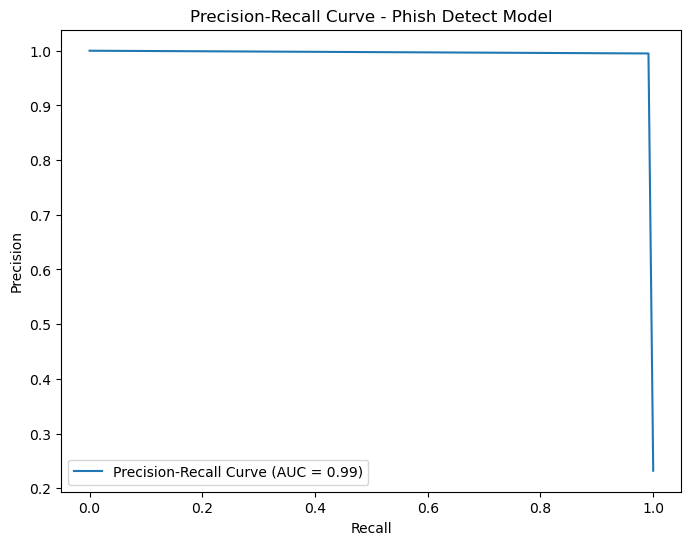

In [61]:
# plot PR Curve
plotPRcurve(recall, precision)

**Model Scenario #2**
- we know having "http" and "https" in the URL has an outsized influence on the target in this dataset.
- Let's see the results on the significantly smaller set of URLs **not** using http or https

In [63]:
# check which cols are https and http
X_test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112544 entries, 79843 to 308686
Data columns (total 18 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   subDomain                    112544 non-null  float64
 1   domain                       112544 non-null  float64
 2   tld                          112544 non-null  float64
 3   urlPart_path                 112544 non-null  float64
 4   urlPart_query                112544 non-null  float64
 5   urlPart_fragment             112544 non-null  float64
 6   TLD Manager                  112544 non-null  float64
 7   isIPaddress                  112544 non-null  bool   
 8   url_Length                   112544 non-null  int64  
 9   urlPart_scheme_ftp           112544 non-null  bool   
 10  urlPart_scheme_http          112544 non-null  bool   
 11  urlPart_scheme_https         112544 non-null  bool   
 12  urlPart_scheme_httpss        112544 non-null  bool   
 13  

> We'll check model results for the data without these...
> - 10  urlPart_scheme_http
> - 11  urlPart_scheme_https

In [65]:
# mask for numpy array - exclude http and https
np_mask_scheme = (X_test_preprocessed[:,10] == 0) & (X_test_preprocessed[:,11] == 0)

In [66]:
# create new filter of predictions bool
predictions_bool = makeBool(predictions[np_mask_scheme])

In [67]:
# Classification Report - scenario #2
print(classification_report(y_test[np_mask_scheme], predictions_bool))

              precision    recall  f1-score   support

       False       1.00      0.90      0.95        10
        True       0.67      1.00      0.80         2

    accuracy                           0.92        12
   macro avg       0.83      0.95      0.87        12
weighted avg       0.94      0.92      0.92        12



In [68]:
# Precision Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test[np_mask_scheme], predictions_bool)
auc_score = auc(recall, precision)

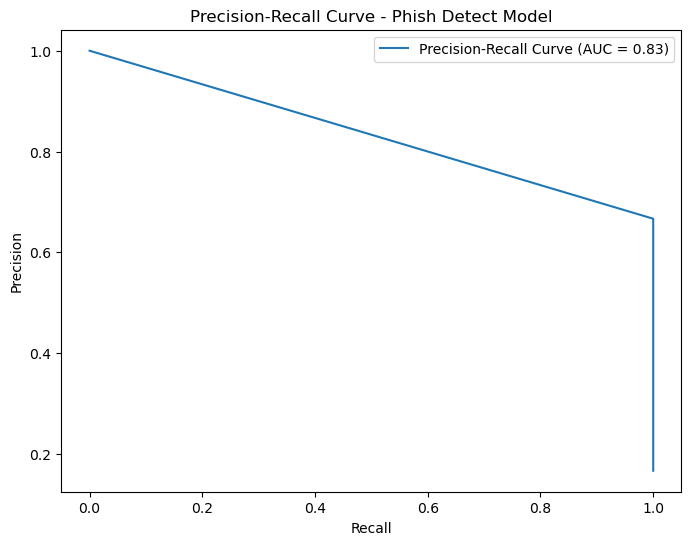

In [69]:
# plot PR curve - scenario #2
plotPRcurve(recall, precision)

> As expected, the results suffer when observing only the non-http and https URLs. Results look more "real world"

##### Select Best Model

###### To do
- TBA